# CCA with WordVectors on single participant

### Import EEG - single subject, single story

In [1]:
import numpy as np
import mne
import os
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.io import wavfile
from scipy import signal
from sklearn.preprocessing import scale
from pyeeg.io import eeglab2mne

subj_id = 3 # id of participant (3 is subject P04)
story_id = 0 # id of stories (1 is AUNP02)

C:\Users\Karen\AppData\Local\conda\conda\envs\mne\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
# %gui qt

# from PyQt5.QtWidgets import QFileDialog

# def gui_fname(dir=None):
#     """Select a directory."""
#     if dir is None: dir ='./'
#     fname = QFileDialog.getExistingDirectory(None, "Select directory...", dir)
#     return fname

In [3]:
# try:
#     experiment_path = '/media/hw2512/SeagateExpansionDrive/EEG_data/Katerina_experiment'
#     os.listdir('/media/hw2512/SeagateExpansionDrive/EEG_data/Katerina_experiment')
# except:
#     experiment_path = gui_fname()

In [4]:
experiment_path = 'L:\Hugo\Katerina_experiment'

In [5]:
eeg_path = os.path.join(experiment_path, "Processed/Fs-125/interp_bad/BP-0.3-65/Blink_pruned/")
list_subjects = os.listdir(eeg_path)
eeg_fname = [f for f in os.listdir(os.path.join(eeg_path, list_subjects[subj_id])) if f.endswith('.set')][0]

event_id = dict(boundary=-1, story_onset=1)
raw = eeglab2mne(os.path.join(eeg_path, list_subjects[subj_id], eeg_fname), load_ica=False, event_id=event_id)
raw.pick_types(eeg=True)

# Filtering the EEG
raw = raw.filter(1, 15, n_jobs=2)

c:\users\karen\onedrive - imperial college london\fyp\code\pyeeg\pyeeg\io.py:173: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id, preload=True)


Used Annotations descriptions: ['boundary', 'story_onset']
Setting up band-pass filter from 1 - 15 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 3.8 Hz
Filter length of 413 samples (3.304 sec) selected


C:\Users\Karen\AppData\Local\conda\conda\envs\mne\lib\site-packages\mne\annotations.py:315: RuntimeWarning: invalid value encountered in less
  out_of_bounds = (absolute_onset > tmax) | (absolute_offset < tmin)
C:\Users\Karen\AppData\Local\conda\conda\envs\mne\lib\site-packages\mne\annotations.py:324: RuntimeWarning: invalid value encountered in greater
  clip_right_elem = (absolute_offset > tmax) & ~out_of_bounds
c:\users\karen\onedrive - imperial college london\fyp\code\pyeeg\pyeeg\io.py:173: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. Please use `read_annotations_eeglab` and create events using `events_from_annotations` to extract the original event structure. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(input_fname=fname, montage=montage_mne, event_id=event_id,

### Import Word-level features

We will load the envelope to align the short stories with the EEG recordings. We will use the word onset and the word vectors for the CCA modelling.

In [6]:
# Import all paths
from pyeeg.io import WordLevelFeatures
stim_path = os.path.join(experiment_path, 'story_parts')
env_path = os.path.join(stim_path, 'alignement_data/')
wordfreq_path = os.path.join(stim_path, 'word_frequencies/')
list_wordfreq_files = [item for item in os.listdir(wordfreq_path) if item.endswith('timed.csv')]
list_stories = [item.strip('_word_freq_timed.csv') for item in list_wordfreq_files]
list_env_files = [os.path.join(env_path, s, s + '_125Hz.Env') for s in list_stories]

# Sort them all in case:
for l in [list_env_files, list_stories, list_wordfreq_files]:
    l.sort()

onset_path = './all_katerina_onsets.mat'
onsets = loadmat(onset_path)['onsets']

# Loading word onset and duration for AUNP02:
wo_path = os.path.join(wordfreq_path, list_wordfreq_files[story_id])
duration_path = os.path.join(env_path, list_env_files[story_id])

# Path to WordVectors
wv_path = os.path.join( os.getcwd(), '../../../../../WordVectors/vectors_correct_header.txt')

In [7]:
wf = WordLevelFeatures(path_praat_env=duration_path, path_wordonsets=wo_path, path_wordvectors=wv_path, keep_vectors=True)

INFO:pyeeg.io:Word flushington not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word bashfulest not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word adulation not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word blush not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word blush not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word paucity not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word fellow-men not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word fastened not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word flushington not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word scraggy not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word timid not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word deprecating not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word uninteresting not in word embedding model;

In [8]:
feat_matrix = wf.align_word_features(features=['wordvectors'], srate=125, wordonset_feature=True)

In [9]:
#feat_matrix = feat_matrix[:, :15]

In [10]:
print(feat_matrix.shape)

(20272, 51)


In [11]:
# Getting EEG data
y = raw.get_data()

# Croping data with indices that match current story for this participant
indices = wf.samples_from_onset(onsets[subj_id, story_id], srate=raw.info['sfreq'])
y = y[:, indices].T

## Run CCA modelling

The CCA_Estimator takes in the matrices X (in this case a time lagged version of the wordvectors) and y (in this case the EEG data of one participant).

In [12]:
from pyeeg.cca import CCA_Estimator

### On word onset

In [13]:
# reshape matrices
x = feat_matrix[:,0][:, None]

In [14]:
cca_onset = CCA_Estimator(tmin=-.2, tmax=.8, srate=raw.info['sfreq'])
cca_onset.fit(x, y, thresh_x=1., thresh_y=0.999, normalise=False, feat_names=["WordVectors"])

INFO:pyeeg.cca:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


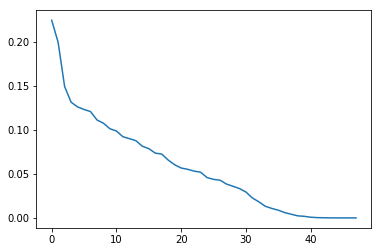

In [15]:
plt.plot(cca_onset.score_)

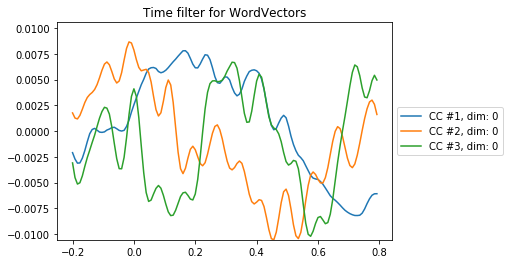

In [16]:
cca_onset.plot_time_filter(n_comp=3)

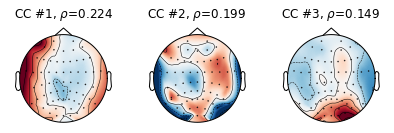

In [17]:
cca_onset.plot_activation_map(raw.info, n_comp=3)

0.22434117505828333
0.19926263365702748
0.14909548462048944
0.13134678041027537
0.12596528238903246


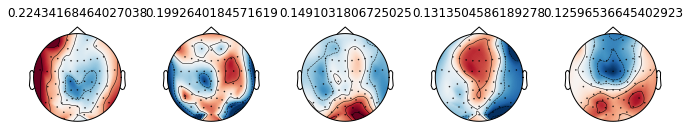

In [18]:
from pyeeg.vizu import topoplot_array
X = np.load(cca_onset.tempX_path_+'.npy')
coefStim_ = cca_onset.coefStim_.reshape((cca_onset.coefStim_.shape[0] * cca_onset.coefStim_.shape[1], cca_onset.coefStim_.shape[2]))
y_temp = np.load(cca_onset.tempy_path_+'.npy')
n_comp=5
feat_id=0
r = np.zeros((64,n_comp))
for c in range(n_comp):
    eeg_proj = y_temp @ cca_onset.coefResponse_[:, c]
    env_proj = X @ coefStim_[:, c]
    for i in range(64):
        r[i,c] = np.corrcoef(y_temp[:,i], eeg_proj)[0,1]
    cc_corr = np.corrcoef(eeg_proj, env_proj)[0,1]
    print(cc_corr)
topoplot_array(r, raw.info, n_topos=n_comp, titles=cca_onset.score_)
mne.viz.tight_layout()

### On word vectors

In [19]:
x = feat_matrix.copy()[:,1:]

In [20]:
cca = CCA_Estimator(tmin=-.2, tmax=.8, srate=raw.info['sfreq'])
cca.fit(x, y, thresh_x=1, thresh_y=0.999, normalise=False, feat_names=["WordVectors"], drop=False)    # best to use all components but only display first few

INFO:pyeeg.cca:Will use lags spanning form tmin to tmax.
To use individual lags, use the `times` argument...


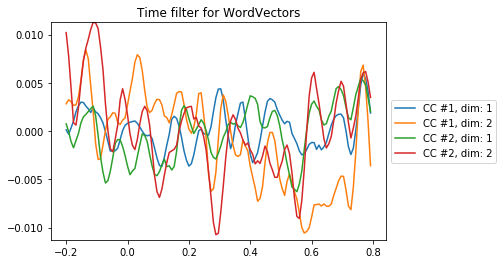

In [21]:
cca.plot_time_filter(n_comp=2, dim=[1,2])

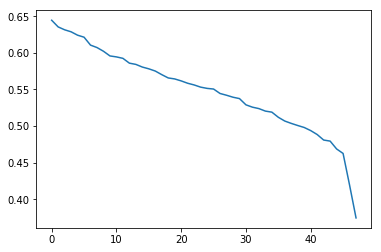

In [22]:
plt.plot(cca.score_)

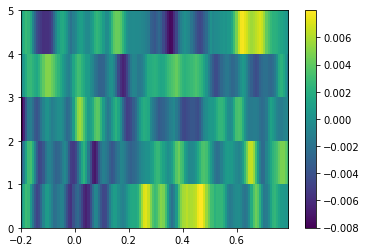

In [23]:
cca.plot_compact_time(n_comp=5)

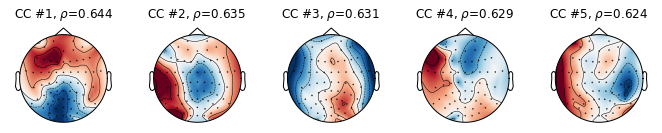

In [24]:
cca.plot_activation_map(raw.info, n_comp=5)

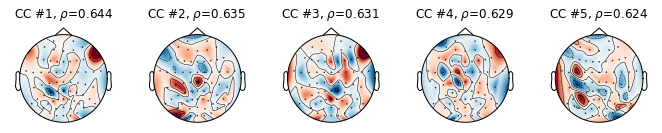

In [25]:
cca.plot_spatial_filter(raw.info, n_comp=5)

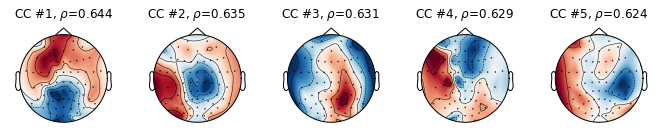

In [26]:
cca.plot_corr(raw.info, n_comp=5)

0.6444322865242028
0.6353274876493328
0.6313901805692457
0.6286373479471814
0.62402494189855


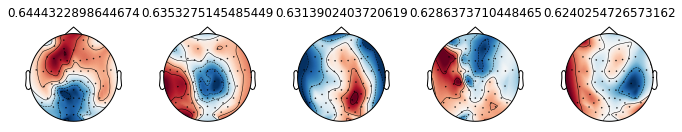

In [27]:
from pyeeg.vizu import topoplot_array
X = np.load(cca.tempX_path_+'.npy')
coefStim_try = cca.coefStim_.reshape((cca.coefStim_.shape[0]*cca.coefStim_.shape[1],cca.coefStim_.shape[2]))
y_tmp = np.load(cca.tempy_path_+'.npy')
n_comp=5
feat_id=1
r = np.zeros((64,n_comp))
for c in range(n_comp):
    eeg_proj = y_tmp @ cca.coefResponse_[:, c]
    env_proj = X @ coefStim_try[:,c]
    for i in range(64):
        r[i,c] = np.corrcoef(y_tmp[:,i], eeg_proj)[0,1]
    cc_corr = np.corrcoef(eeg_proj, env_proj)[0,1]
    print(cc_corr)
topoplot_array(r, raw.info, n_topos=n_comp, titles=cca.score_)
mne.viz.tight_layout()

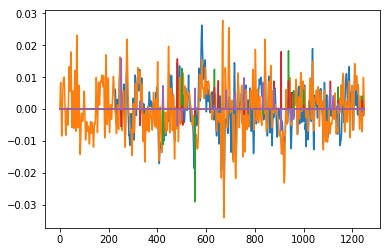

In [28]:
#%matplotlib qt
plt.plot(env_proj[:125*10])
plt.plot(eeg_proj[:125*10])
plt.plot(x[:125*10, :3]/2*0.03)

## Clustering Word vectors

Quick and dirty.. Simple, I meant simple.

In [29]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [30]:
kmeans = KMeans(n_clusters=20, n_jobs=-1)
kmeans.fit(wf.wordvectors_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [31]:
mkmeans = MiniBatchKMeans(n_clusters=20)
mkmeans.fit(wf.wordvectors_matrix)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=20,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [32]:
import gensim

In [33]:
wordvect = gensim.models.KeyedVectors.load_word2vec_format(wv_path, binary=False)

In [34]:
mkmeans.cluster_centers_[8]

array([-0.2477367 ,  0.22852618, -0.1002644 ,  0.12415761, -0.4956917 ,
       -0.07152411, -0.4920822 , -0.48396087,  0.09622595, -0.05414493,
        0.251617  ,  0.17082417, -0.2857864 ,  0.02930446,  0.24019988,
        0.00315229, -0.25714862, -0.06387921, -0.47001642, -0.05488912,
       -0.19465353, -0.6630072 , -0.47710928, -0.07582159,  0.27264416,
        0.21378492, -0.61451566, -0.42613176,  0.00387523,  0.5323898 ,
       -0.6456418 ,  0.01750688, -0.19508182, -0.11657512,  0.38001353,
       -0.03536054, -0.30923873, -0.18577228,  0.10756919,  0.3196624 ,
       -0.35398892, -0.21085565, -0.29734465,  0.07559531,  0.4170356 ,
       -0.3519385 , -0.06775741, -0.00585312,  0.6192051 ,  0.32417396],
      dtype=float32)

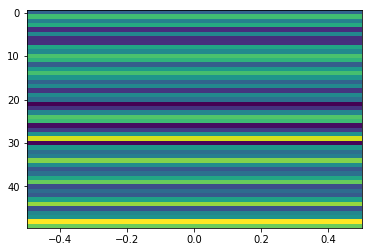

In [35]:
plt.imshow(mkmeans.cluster_centers_[8][:, None], aspect="auto")

In [36]:
for k, cc in enumerate(kmeans.cluster_centers_):
    print("Most similar to cluster %d"%(k + 1))
    print("For normal kmeans")
    print([w for (w, simil) in wordvect.similar_by_vector(cc, topn=5)])
    print("For mini batch kmeans")
    print([w for (w, simil) in wordvect.similar_by_vector(mkmeans.cluster_centers_[k], topn=5)])
    print()

Most similar to cluster 1
For normal kmeans
['topeka', 'ohio', 'culver', 'kansas', 'birmingham']
For mini batch kmeans
['paying', 'refusing', 'desiring', 'collect', 'repay']

Most similar to cluster 2
For normal kmeans
['internet', 'interactive', 'network', 'format', 'interface']
For mini batch kmeans
['revealing', 'unrealistic', 'simplistic', 'disturbing', 'veiled']

Most similar to cluster 3
For normal kmeans
['after', 'first', 'later', 'during', 'last']
For mini batch kmeans
['karate', 'okinawan', 'martial', 'fencing', 'trigonometry']

Most similar to cluster 4
For normal kmeans
['donaldson', 'gordon', 'newman', 'cooke', 'irwin']
For mini batch kmeans
['lupercalia', 'gaucho', 'minaret', 'atharva', 'dispensational']

Most similar to cluster 5
For normal kmeans
['pittori', 'liberaci', 'ldskaparm', 'piovra', 'moyne']
For mini batch kmeans
['only', 'this', 'although', 'than', 'however']

Most similar to cluster 6
For normal kmeans
['inches', 'per', 'centimeters', 'lyr', 'approximately']

C:\Users\Karen\AppData\Local\conda\conda\envs\mne\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
